# pos - tagging

In [1]:
import pandas as pd

df = pd.read_csv("even_semi_annotated_final.csv")
df = df.drop(columns=["TYPE1"])
df.to_csv("ground_truth.csv", index=False)

In [2]:
df = pd.read_csv ("ground_truth.csv")
df = df.rename(columns={"TYPE2": "type"})

In [3]:
df.to_csv("ground_truth_ner.csv")

## gabung token jadi kalimat & ambil entitas ground truth

In [5]:
import pandas as pd

# === Load CSV ===
df = pd.read_csv("ground_truth_ner.csv")
df.columns = df.columns.str.strip()

# === Group by story_id + sentence_id ===
grouped = df.groupby(["story_id", "sentence_id"])

results = []
for (story_id, sentence_id), group in grouped:
    sentence = " ".join(group["word"])
    
    # Ambil entitas gabungan dari B-TOKOH + I-TOKOH
    entities = []
    current_entity = []
    
    for _, row in group.iterrows():
        tag = row["type"]
        word = row["word"]
        
        if tag == "B-TOKOH":
            if current_entity:
                entities.append(" ".join(current_entity))
                current_entity = []
            current_entity = [word]
        elif tag == "I-TOKOH":
            current_entity.append(word)
        else:
            if current_entity:
                entities.append(" ".join(current_entity))
                current_entity = []
    
    if current_entity:
        entities.append(" ".join(current_entity))

    results.append({
        "story_id": story_id,
        "sentence_id": sentence_id,
        "sentence": sentence,
        "entities": entities
    })

# === Save to CSV ===
df_result = pd.DataFrame(results)
df_result.to_csv("sentence_level_ground_truth.csv", index=False)

print(df_result.head())


   story_id  sentence_id                                           sentence  \
0         7            0  Alkisah Rakyat Tersebutlah kisah di zaman dahu...   
1         7            1  Penduduknya jarang tempat tinggalnya masih ber...   
2         7            2  Pada suatu kampung tinggal sepasang suami istri .   
3         7            3         Mereka mempunyai dua orang anak lakilaki .   
4         7            4  Anak yang sulung bernama Ahmad dan anak kedua ...   

            entities  
0                 []  
1                 []  
2                 []  
3                 []  
4  [Ahmad, Muhammad]  


In [ ]:
import stanza
import pandas as pd
import spacy_stanza
import os

# Unduh model Bahasa Indonesia (hanya perlu sekali)
stanza.download("id")

# Load pipeline Bahasa Indonesia
nlp = spacy_stanza.load_pipeline("id")

# Load data kalimat
df = pd.read_csv("sentence_level_ground_truth.csv")

# Fungsi untuk menggabungkan token PROPN yang berurutan jadi entitas
def extract_character_entities(text):
    doc = nlp(text)
    entities = []
    current_entity = []

    for token in doc:
        if token.pos_ == "PROPN" and token.text.istitle():
            current_entity.append(token.text)
        else:
            if current_entity:
                entities.append(" ".join(current_entity))
                current_entity = []
    
    # Tangani sisa entitas di akhir kalimat
    if current_entity:
        entities.append(" ".join(current_entity))

    return entities

# Tambahkan kolom hasil prediksi entitas ke DataFrame
df["predicted_entities"] = df["sentence"].apply(extract_character_entities)

# Buat folder output kalau belum ada
output_dir = "grouped_pos_tagged"
os.makedirs(output_dir, exist_ok=True)

# Kelompokkan berdasarkan story_id dan simpan masing-masing ke file
for story_id, group in df.groupby("story_id"):
    filename = f"{output_dir}/story_{story_id}_pos_tagged.csv" 
    group.to_csv(filename, index=False)

print("✅ Selesai! Hasil prediksi disimpan per story_id di folder 'grouped_pos_tagged'")


c:\Users\rayssa\Documents\nusantara-character-classification\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-18 20:03:45 INFO: Downloading default packages for language: id (Indonesian) ...
2025-07-18 20:03:46 INFO: File exists: C:\Users\rayssa\stanza_resources\id\default.zip
2025-07-18 20:03:48 INFO: Finished downloading models and saved to C:\Users\rayssa\stanza_resources.
2025-07-18 20:03:48 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES
2025-07-18 20:03:48 INFO: Loading these models for language: id (Indonesian):
| Processor    | Package      |
-------------------------------
| tokenize     | gsd          |
| mwt          | gsd          |
| pos        

✅ Selesai! Hasil prediksi disimpan per story_id di folder 'grouped_pos_tagged'


In [10]:
import pandas as pd
import glob
import ast
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# Load seluruh prediksi per story
all_files = glob.glob("grouped_pos_tagged/story_*_pos_tagged.csv")
df = pd.concat([pd.read_csv(f) for f in all_files], ignore_index=True)
df.columns = df.columns.str.strip()

# Pastikan kolom berbentuk list
df["entities"] = df["entities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)
df["predicted_entities"] = df["predicted_entities"].apply(lambda x: ast.literal_eval(x) if isinstance(x, str) else x)

# Evaluasi per kalimat dan entitas dengan TN
def evaluate_strict_per_sentence_with_tn(df):
    results = []
    sentence_level = []

    for story_id, group in df.groupby("story_id"):
        TP, FP, FN, TN = 0, 0, 0, 0

        for _, row in group.iterrows():
            gt = set(row["entities"])
            pred = set(row["predicted_entities"])

            tp = len(gt & pred)
            fn = len(gt - pred)
            fp = len(pred - gt)

            # Estimasi TN: semua token yang bukan entitas & tidak diprediksi
            tokens = row["sentence"].split()
            all_token_set = set(tokens)
            tn = len([t for t in all_token_set if t not in gt and t not in pred])

            TP += tp
            FP += fp
            FN += fn
            TN += tn

            sentence_level.append({
                "story_id": story_id,
                "sentence_id": row["sentence_id"],
                "TP": tp,
                "FP": fp,
                "FN": fn,
                "TN": tn,
                "GT_count": len(gt),
                "Pred_count": len(pred),
                "Entities_GT": list(gt),
                "Entities_Pred": list(pred)
            })

        precision = TP / (TP + FP) if (TP + FP) > 0 else 0
        recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
        f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        accuracy  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0

        results.append({
            "story_id": story_id,
            "TP": TP,
            "FP": FP,
            "FN": FN,
            "TN": TN,
            "precision": precision,
            "recall": recall,
            "f1_score": f1,
            "accuracy": accuracy,
        })

    return pd.DataFrame(results), pd.DataFrame(sentence_level)

# Jalankan evaluasi
story_eval_df, sentence_eval_df = evaluate_strict_per_sentence_with_tn(df)

# Simpan hasil
story_eval_df.to_csv("evaluation_per_story_strict_with_tn.csv", index=False)
sentence_eval_df.to_csv("evaluation_per_sentence_detailed_with_tn.csv", index=False)

print("✅ Evaluasi selesai per kalimat & entitas (dengan TN)!")


✅ Evaluasi selesai per kalimat & entitas (dengan TN)!


In [6]:
import pandas as pd

# Load hasil evaluasi per story
df = pd.read_csv("evaluation_per_story_strict.csv")

# Hitung macro average (rata-rata dari semua story)
macro_precision = df["precision"].mean()
macro_recall    = df["recall"].mean()
macro_f1        = df["f1_score"].mean()
macro_accuracy  = df["accuracy"].mean()

# Tampilkan hasil
print("📊 Macro-Averaged Evaluation (Strict Matching):")
print(f"Macro Precision : {macro_precision:.4f}")
print(f"Macro Recall    : {macro_recall:.4f}")
print(f"Macro F1-Score  : {macro_f1:.4f}")
print(f"Macro Accuracy  : {macro_accuracy:.4f}")


📊 Macro-Averaged Evaluation (Strict Matching):
Macro Precision : 0.6105
Macro Recall    : 0.3959
Macro F1-Score  : 0.4658
Macro Accuracy  : 0.3272


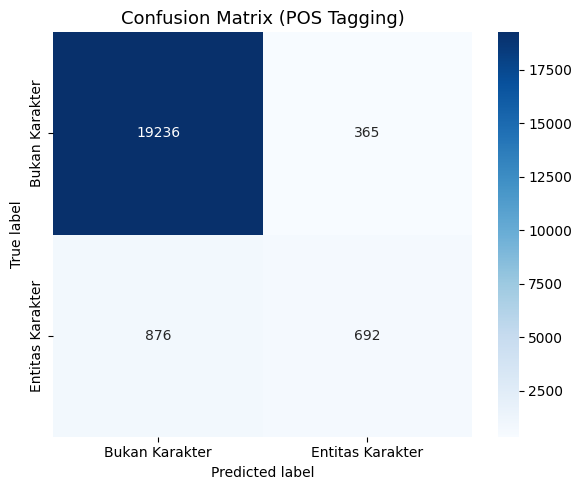

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load file evaluasi
df = pd.read_csv("evaluation_per_story_strict_with_tn.csv")

# Hitung total TP, FP, FN, TN
TP_total = df["TP"].sum()
FP_total = df["FP"].sum()
FN_total = df["FN"].sum()
TN_total = df["TN"].sum()

# Urutkan agar sesuai dengan contoh:
# [[TN, FP],
#  [FN, TP]]
conf_matrix = np.array([
    [TN_total, FP_total],
    [FN_total, TP_total]
])

# Label seperti contoh kamu
x_labels = ["Bukan Karakter", "Entitas Karakter"]
y_labels = ["Bukan Karakter", "Entitas Karakter"]

# Plot confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=x_labels, yticklabels=y_labels)

plt.title("Confusion Matrix (POS Tagging)", fontsize=13)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.tight_layout()
plt.show()


In [12]:
import pandas as pd

# Load file evaluasi lengkap
df = pd.read_csv("evaluation_per_story_strict_with_tn.csv")

# Hitung total TP, FP, FN, TN dari seluruh story
TP = df["TP"].sum()
FP = df["FP"].sum()
FN = df["FN"].sum()
TN = df["TN"].sum()

# Hitung metrik evaluasi
precision = TP / (TP + FP) if (TP + FP) > 0 else 0
recall    = TP / (TP + FN) if (TP + FN) > 0 else 0
accuracy  = (TP + TN) / (TP + TN + FP + FN) if (TP + TN + FP + FN) > 0 else 0
f1        = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

# Tampilkan hasil
print("📊 Confusion-Matrix-Based Evaluation (Strict Matching):")
print(f"Precision : {precision:.4f}")
print(f"Recall    : {recall:.4f}")
print(f"F1-Score  : {f1:.4f}")
print(f"Accuracy  : {accuracy:.4f}")


📊 Confusion-Matrix-Based Evaluation (Strict Matching):
Precision : 0.6547
Recall    : 0.4413
F1-Score  : 0.5272
Accuracy  : 0.9414


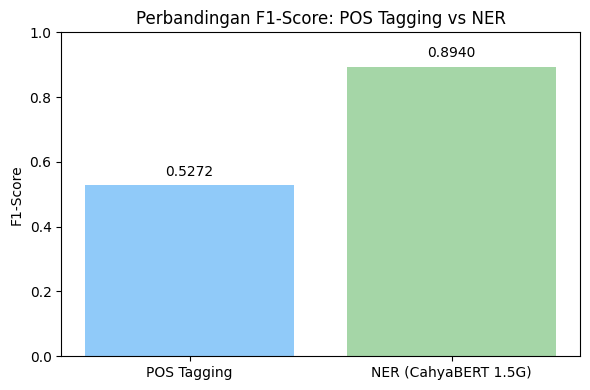

In [13]:
import matplotlib.pyplot as plt

# Data F1-score
techniques = ['POS Tagging', 'NER (CahyaBERT 1.5G)']
f1_scores = [0.5272, 0.8940]
colors = ['#90caf9', '#a5d6a7']  # soft blue & green

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(techniques, f1_scores, color=colors)
plt.ylim(0, 1)
plt.ylabel('F1-Score')
plt.title('Perbandingan F1-Score: POS Tagging vs NER')

# Tambahkan nilai di atas bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [15]:
import pandas as pd
import ast

# Path ke file CSV
file_path = "grouped_pos_tagged/story_16_pos_tagged.csv"

# Baca file
df = pd.read_csv(file_path)

# Set untuk menyimpan entitas unik
unique_entities = set()

# Loop tiap baris di kolom 'predicted_entities'
for row in df["predicted_entities"]:
    try:
        entities = ast.literal_eval(row)
        unique_entities.update(entities)
    except:
        continue

# Ubah ke list, urutkan, dan print dalam format yang diminta
formatted = "[" + ", ".join(f"'{e}'" for e in sorted(unique_entities)) + "]"
print(formatted)


['Ayah', 'Danau Laut Tador', 'Halini', 'Ibu', 'Ibu Tador', 'Keluarga Tador', 'Kesdihan', 'Kesedihan', 'Laut', 'Ramadhan', 'Seruan', 'Tador']
